This is from http://deeplearning.net/tutorial/lenet.html

In [3]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d

import numpy

rng = numpy.random.RandomState(23455)

# instantiate 4D tensor for input
input = T.tensor4(name='input')

# initialize shared variable for weights.
w_shp = (2, 3, 9, 9)
w_bound = numpy.sqrt(3 * 9 * 9)
W = theano.shared( numpy.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')

# initialize shared variable for bias (1D tensor) with random values
# IMPORTANT: biases are usually initialized to zero. However in this
# particular application, we simply apply the convolutional layer to
# an image without learning the parameters. We therefore initialize
# them to random values to "simulate" learning.
b_shp = (2,)
print(b_shp)
print(rng.uniform(low=-.5, high=.5, size=b_shp), numpy.asarray(
                                        rng.uniform(low=-.5, high=.5, size=b_shp),
                                        dtype=input.dtype))
b = theano.shared(numpy.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv2d(input, W)
print(conv_out)

# build symbolic expression to add bias and apply activation function, i.e. produce neural net layer output
# A few words on ``dimshuffle`` :
#   ``dimshuffle`` is a powerful tool in reshaping a tensor;
#   what it allows you to do is to shuffle dimension around
#   but also to insert new ones along which the tensor will be
#   broadcastable;
#   dimshuffle('x', 2, 'x', 0, 1)
#   This will work on 3d tensors with no broadcastable
#   dimensions. The first dimension will be broadcastable,
#   then we will have the third dimension of the input tensor as
#   the second of the resulting tensor, etc. If the tensor has
#   shape (20, 30, 40), the resulting tensor will have dimensions
#   (1, 40, 1, 20, 30). (AxBxC tensor is mapped to 1xCx1xAxB tensor)
#   More examples:
#    dimshuffle('x') -> make a 0d (scalar) into a 1d vector
#    dimshuffle(0, 1) -> identity
#    dimshuffle(1, 0) -> inverts the first and second dimensions
#    dimshuffle('x', 0) -> make a row out of a 1d vector (N to 1xN)
#    dimshuffle(0, 'x') -> make a column out of a 1d vector (N to Nx1)
#    dimshuffle(2, 0, 1) -> AxBxC to CxAxB
#    dimshuffle(0, 'x', 1) -> AxB to Ax1xB
#    dimshuffle(1, 'x', 0) -> AxB to Bx1xA
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))

# create theano function to compute filtered images
f = theano.function([input], output)

(2,)
(array([-0.3943425 ,  0.16818965]), array([-0.06044631, -0.08006482]))
AbstractConv2d{border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=(None, None, None, None), kshp=(None, None, None, None)}.0


((639, 516, 3), (3, 639, 516))


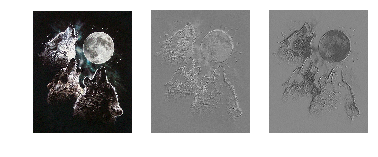

In [4]:
import numpy
import pylab
from PIL import Image

# open random image of dimensions 639x516
img = Image.open('doc/images/3wolfmoon.jpg')
# dimensions are (height, width, channel)
img = numpy.asarray(img, dtype='float64') / 256.

# put image in 4D tensor of shape (1, 3, height, width)
print(img.shape, img.transpose(2, 0, 1).shape)
img_ = img.transpose(2, 0, 1).reshape(1, 3, 639, 516)
filtered_img = f(img_)

# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :])
pylab.show()


In [7]:
#### MaxPooling
from theano.tensor.signal import pool

input = T.dtensor4('input')
maxpool_shape = (2, 2)
pool_out = pool.pool_2d(input, maxpool_shape, ignore_border=True)
f = theano.function([input],pool_out)

invals = numpy.random.RandomState(1).rand(3, 2, 5, 5)
print('With ignore_border set to True:')
print 'invals[0, 0, :, :] =\n', invals[0, 0, :, :]
print 'output[0, 0, :, :] =\n', f(invals)[0, 0, :, :]

pool_out = pool.pool_2d(input, maxpool_shape, ignore_border=False)

f = theano.function([input],pool_out)
print 'With ignore_border set to False:'
print 'invals[1, 0, :, :] =\n ', invals[1, 0, :, :]
print 'output[1, 0, :, :] =\n ', f(invals)[1, 0, :, :]

With ignore_border set to True:
invals[0, 0, :, :] =
[[  4.17022005e-01   7.20324493e-01   1.14374817e-04   3.02332573e-01
    1.46755891e-01]
 [  9.23385948e-02   1.86260211e-01   3.45560727e-01   3.96767474e-01
    5.38816734e-01]
 [  4.19194514e-01   6.85219500e-01   2.04452250e-01   8.78117436e-01
    2.73875932e-02]
 [  6.70467510e-01   4.17304802e-01   5.58689828e-01   1.40386939e-01
    1.98101489e-01]
 [  8.00744569e-01   9.68261576e-01   3.13424178e-01   6.92322616e-01
    8.76389152e-01]]
output[0, 0, :, :] =
[[ 0.72032449  0.39676747]
 [ 0.6852195   0.87811744]]
With ignore_border set to False:
invals[1, 0, :, :] =
  [[ 0.01936696  0.67883553  0.21162812  0.26554666  0.49157316]
 [ 0.05336255  0.57411761  0.14672857  0.58930554  0.69975836]
 [ 0.10233443  0.41405599  0.69440016  0.41417927  0.04995346]
 [ 0.53589641  0.66379465  0.51488911  0.94459476  0.58655504]
 [ 0.90340192  0.1374747   0.13927635  0.80739129  0.39767684]]
output[1, 0, :, :] =
  [[ 0.67883553  0.58930554

In [10]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            input_shape=image_shape
        )

        # pool each feature map individually, using maxpooling
        pooled_out = pool.pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input
        

In [11]:
    x = T.matrix('x')   # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (28, 28) is the size of MNIST images.
    layer0_input = x.reshape((batch_size, 1, 28, 28))

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
    # maxpooling reduces this further to (24/2, 24/2) = (12, 12)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=layer0_input,
        image_shape=(batch_size, 1, 28, 28),
        filter_shape=(nkerns[0], 1, 5, 5),
        poolsize=(2, 2)
    )

    # Construct the second convolutional pooling layer
    # filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
    # maxpooling reduces this further to (8/2, 8/2) = (4, 4)
    # 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer0.output,
        image_shape=(batch_size, nkerns[0], 12, 12),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )

    # the HiddenLayer being fully-connected, it operates on 2D matrices of
    # shape (batch_size, num_pixels) (i.e matrix of rasterized images).
    # This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
    # or (500, 50 * 4 * 4) = (500, 800) with the default values.
    layer2_input = layer1.output.flatten(2)

    # construct a fully-connected sigmoidal layer
    layer2 = HiddenLayer(
        rng,
        input=layer2_input,
        n_in=nkerns[1] * 4 * 4,
        n_out=500,
        activation=T.tanh
    )

    # classify the values of the fully-connected sigmoidal layer
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # the cost we minimize during training is the NLL of the model
    cost = layer3.negative_log_likelihood(y)

    # create a function to compute the mistakes that are made by the model
    test_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]

    train_model = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

... building the model


NameError: name 'batch_size' is not defined